In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"  # Use only GPU 0


In [8]:
import torch
from transformers import DataCollatorWithPadding

In [2]:
texts = ["Hello world", "How are you?"]

In [3]:

# Tokenize
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-1B')
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids("<|reserved_special_token_0|>")
tokens = [tokenizer(t) for t in texts]

# Default collate function 
collate_fn = DataCollatorWithPadding(tokenizer, padding=True) #padding=True, 'max_length'

dataloader = torch.utils.data.DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=2) 
for batch in dataloader:
    print(batch)
    break

{'input_ids': tensor([[128000,   9906,   1917, 128002, 128002],
        [128000,   4438,    527,    499,     30]]), 'attention_mask': tensor([[1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1]])}


In [5]:
from transformers import DataCollatorForLanguageModeling
from transformers import AutoTokenizer

texts = [
  "The quick brown fox jumps over the lazy dog.",
  "I am learning about NLP and AI today"  
]

# Tokenize
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokens = [tokenizer(t) for t in texts]

collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
dataloader = torch.utils.data.DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=2)

for batch in dataloader:
    print(batch)

{'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102],
        [  101,  1045,  2572,  4083,  2055, 17953,  2361,  1998,  9932,  2651,
           102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]), 'labels': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102],
        [  101,  1045,  2572,  4083,  2055, 17953,  2361,  1998,  9932,  2651,
           102,  -100]])}


In [6]:
collate_fn(tokens)

{'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102],
        [  101,  1045,  2572,  4083,  2055, 17953,  2361,  1998,  9932,  2651,
           102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]), 'labels': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102],
        [  101,  1045,  2572,  4083,  2055, 17953,  2361,  1998,  9932,  2651,
           102,  -100]])}

In [9]:
import wandb
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForLanguageModeling
)
import math
import torch
from sklearn.metrics import accuracy_score  # This will no longer be used but kept for reference

In [10]:
#  Initialize WandB
wandb.init(
    project="COT",
    name="Value Model: Llama-3.2-1B-Instruct-LM"
)

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Ensure this is the correct model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize the model for causal language modeling
model = AutoModelForCausalLM.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Add the special tokens to the tokenizer
special_tokens_dict = {
    'additional_special_tokens': [
        '<|reserved_special_token_10|>',
        '<|reserved_special_token_11|>',
        '<|reserved_special_token_12|>',
        '<|reserved_special_token_13|>',
        '[PAD]'
    ]
}
# Add pad token
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = '[PAD]'
tokenizer.pad_token_id = tokenizer.eos_token_id  # Assuming pad token is same as eos
model.resize_token_embeddings(len(tokenizer))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: shanghong_sim (stlm). Use `wandb login --relogin` to force relogin


Embedding(128257, 2048)

In [11]:
# Define the dataset and tokenization function
dataset = load_dataset("LeonGuertler/PRM800K_train2_base_sft")
dataset = dataset["train"].train_test_split(test_size=0.01)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # max_length=512,          # Adjust as needed
        padding=False            # Let the data collator handle padding
    )

# Apply tokenization and remove unnecessary columns
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]  # Remove 'text' column after tokenization
)

# Initialize DataCollatorForLanguageModeling for dynamic padding and next token prediction
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Set to False for causal language modeling
)

Map: 100%|██████████| 978/978 [00:00<00:00, 7187.98 examples/s]


In [40]:
dataloader = torch.utils.data.DataLoader(tokenized_datasets["train"], collate_fn=data_collator, batch_size=2)

for batch in dataloader:
    print(batch)
    break

{'input_ids': tensor([[128000,   4438,   1690,   6928,   7698,   3512,  42314,    315,    400,
           1049,     19,  48922,   1049,     19,  32816,    527,  76016,    555,
           7041,    220,   1049,     19,   6928,  26864,   5380, 128018,     40,
           1440,    430,    311,   1505,    279,   1396,    315,   6928,   7698,
           3512,  42314,    315,    264,   1396,     11,    358,   1205,    311,
           8331,    433,   1139,   1202,  10461,   9547,    323,   1005,    264,
          15150,   3196,    389,    279,    506,   2767,    315,   1884,   9547,
             13, 128019,    271, 128018,   4516,     11,   1176,    358,   1205,
            311,   8331,    220,   1049,     19,     13, 128019,    271, 128018,
             40,    649,   1518,    430,    433,    374,   1524,     11,    779,
            433,    374,  76016,    555,    220,     17,     13, 128019,    271,
         128018,  12792,   6714,    555,    220,     17,     11,    358,    636,
            22

In [41]:
# Assuming 'model' is your loaded model
device = next(model.parameters()).device
print(f"Model is loaded on: {device}")


Model is loaded on: cuda:0


In [44]:
inputs = {k: v.to("cuda") for k, v in batch.items()}
inputs

# Forward pass
with torch.no_grad():  # Disable gradient calculation for inspection
    outputs = model(**inputs)
print("Model outputs:", outputs)

# Assuming output is of type CausalLMOutputWithPast
logits = outputs.logits
print(f'{logits=}')

# Get the token IDs for the most likely tokens
predicted_token_ids = logits.argmax(dim=-1)
print(f'{predicted_token_ids}')


Model outputs: CausalLMOutputWithPast(loss=tensor(2.6180, device='cuda:0'), logits=tensor([[[ 2.8333e+00,  3.5809e+00,  7.0268e+00,  ..., -1.2469e+00,
          -1.2468e+00, -1.0438e-01],
         [ 5.3712e+00,  3.5411e+00,  3.3080e+00,  ..., -1.5862e+00,
          -1.5861e+00,  1.4847e-01],
         [ 4.3651e+00,  3.4798e+00,  2.5431e+00,  ..., -2.2675e+00,
          -2.2670e+00, -3.8002e-01],
         ...,
         [-6.6528e-03,  6.4952e-01, -1.9409e+00,  ...,  3.1702e+00,
           3.1707e+00, -2.3785e+00],
         [-3.5629e-02,  2.3069e-01, -1.9618e+00,  ...,  3.1515e+00,
           3.1520e+00, -2.1424e+00],
         [-2.6002e-01, -1.0301e-01, -1.8329e+00,  ...,  3.1335e+00,
           3.1341e+00, -2.1829e+00]],

        [[ 2.8333e+00,  3.5809e+00,  7.0268e+00,  ..., -1.2469e+00,
          -1.2468e+00, -1.0438e-01],
         [ 7.7562e+00,  4.2161e+00,  7.5313e+00,  ..., -3.0732e-02,
          -3.1677e-02, -1.9327e+00],
         [ 1.0595e+01,  6.5003e+00,  4.0325e+00,  ..., -2.555

In [45]:
# Assuming 'tokenizer' is your model's tokenizer
decoded_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

print(decoded_text)


Tags to days integers solutionsisors of n$$1003}$ are less by $ 44?

 integers?

##

 can that the solve the number of div integer divisors of a number, we can to prime the into primes prime factors. then the formula. on the exponents of the prime.assistant####, let, need to factor $2004 into##200 = factor that  is equal, so I is divisible by 2.IIiding  2, I get 1002.IDiv is also even, so it can divide by 2 again.Div gives  501.Now I I501 is  divisible by 2, so it is divisible by 3 andDividing by 3, I get 167.Now is still prime number, so it can divide it further further.SoNow, the2004 = equal to 2^2 * 3^ 167.Now, I need to find  to the power of 2004. get 2004^{2004}$.I is I need to multiply  exponents of  prime by 2004.I, the2004^{2004}$ is equal to $2^{4008} \times 3^{2004} \times 167^{2004}$.Now of####^{


In [4]:
from transformers import HfArgumentParser, TrainingArguments
parser = HfArgumentParser(TrainingArguments)
training_args = parser.parse_json_file(json_file="training_configs/trainer_config.json")

In [5]:
training_args

(TrainingArguments(
 _n_gpu=4,
 accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
 adafactor=False,
 adam_beta1=0.9,
 adam_beta2=0.999,
 adam_epsilon=1e-08,
 auto_find_batch_size=False,
 batch_eval_metrics=False,
 bf16=False,
 bf16_full_eval=False,
 data_seed=None,
 dataloader_drop_last=False,
 dataloader_num_workers=0,
 dataloader_persistent_workers=False,
 dataloader_pin_memory=True,
 dataloader_prefetch_factor=None,
 ddp_backend=None,
 ddp_broadcast_buffers=None,
 ddp_bucket_cap_mb=None,
 ddp_find_unused_parameters=None,
 ddp_timeout=1800,
 debug=[],
 deepspeed=None,
 disable_tqdm=False,
 dispatch_batches=None,
 do_eval=True,
 do_predict=False,
 do_train=False,
 eval_accumulation_steps=None,
 eval_delay=0,
 eval_do_concat_batches=True,
 eval_on_start=False,
 eval_steps=None,
 eval_strategy=IntervalStrategy.EPOCH,
 eval_u

In [14]:
len(tokenizer(dataset['train']['text'][0])['input_ids'])

390

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 97782
    })
})

In [18]:
dataset = dataset["train"].train_test_split(test_size=0.01)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 96804
    })
    test: Dataset({
        features: ['text'],
        num_rows: 978
    })
})


Counting Tokens: 100%|██████████| 978/978 [00:00<00:00, 1567.24it/s]


187
Plotting ....


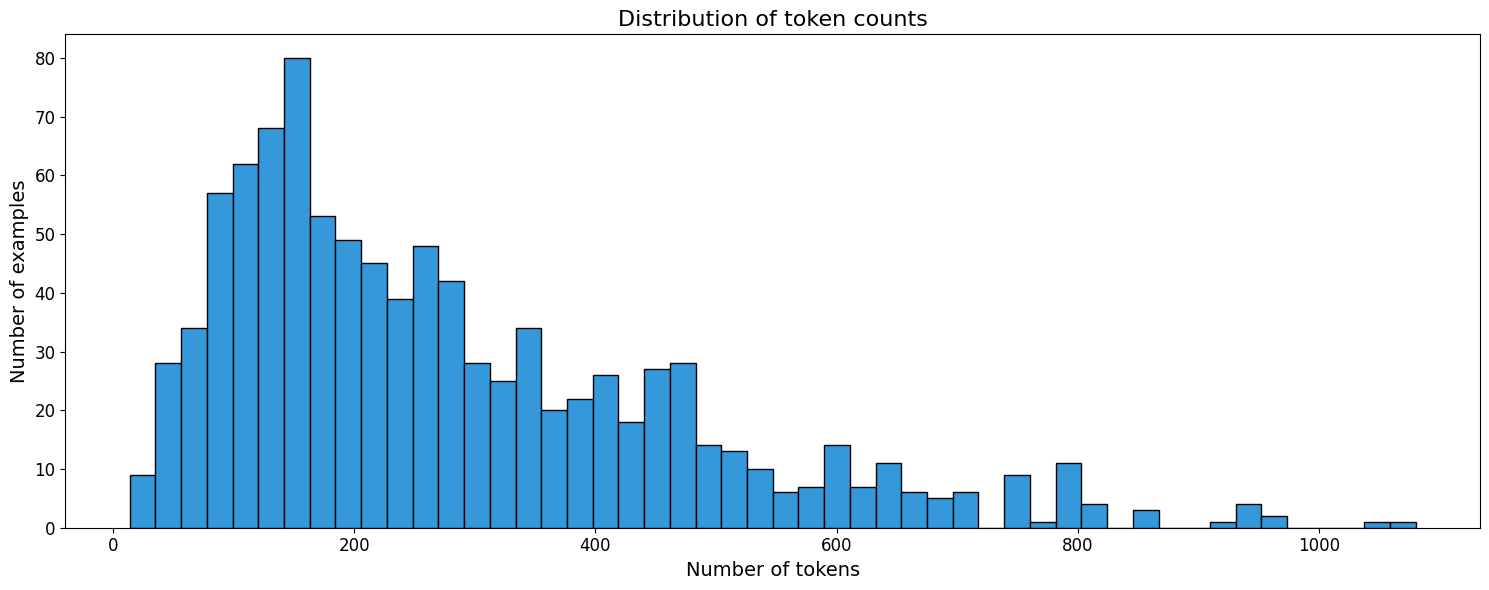

In [21]:
from transformers import AutoTokenizer,AutoModelForCausalLM
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset

model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    revision="main",
    use_fast=True, 
    trust_remote_code=True
)
special_tokens_dict = {
    'additional_special_tokens': [
        '<|reserved_special_token_10|>',
        '<|reserved_special_token_11|>',
        '<|reserved_special_token_12|>',
        '<|reserved_special_token_13|>',
        '[PAD]'
    ]
}
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = '[PAD]'
tokenizer.pad_token_id = tokenizer.eos_token_id  # Assuming pad token is same as eos
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id # Set pad token ID in model config


# Define the dataset and tokenization function
dataset = load_dataset("LeonGuertler/PRM800K_train2_base_sft")
dataset = dataset["train"].train_test_split(test_size=0.01)
print(dataset)

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer(example)['input_ids']) for example in tqdm(dataset["test"]["text"], desc="Counting Tokens")]

# Print the token count for the first row
print(instruction_token_counts[0])

print("Plotting ....")
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts")